Evaluation (for TFIDF-RF)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

dataset_valid_folder_path = Path('../../dataset/sa/sampled_valid_2023-12-16/')

dataset_val_bal = pd.read_pickle(dataset_valid_folder_path / 'validation_balanced.pkl')
dataset_val_imbal = pd.read_pickle(dataset_valid_folder_path / 'validation_imbalanced.pkl')

In [2]:
X_imbal_valid = dataset_val_imbal['review_text']
y_imbal_valid = dataset_val_imbal['review_score']

X_bal_valid = dataset_val_bal['review_text']
y_bal_valid = dataset_val_bal['review_score']

In [5]:
# data cleaning

import sys
 
# setting path
sys.path.append('../')

import str_cleaning_functions

X_imbal_valid = str_cleaning_functions.cleaning_arr(X_imbal_valid)
X_bal_valid = str_cleaning_functions.cleaning_arr(X_bal_valid)

X_bal_valid = X_bal_valid.to_numpy()
y_bal_valid = y_bal_valid.to_numpy()

X_imbal_valid = X_imbal_valid.to_numpy()
y_imbal_valid = y_imbal_valid.to_numpy()

In [6]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Validation (imbalanced) set
review_score
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
review_score
0    150672
1    150672
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


---

Load the models (optional)

In [7]:
# indicate which models to be loaded for creating evaluation graphs

# set some parameters of the training
DATASET_LIST = [120, 240, 480]
DATASET_LIST_INDEX = 0
DATASET_IS_BALANCED = True

In [9]:
from datetime import datetime
import pickle

models_date = datetime(2023, 12, 16)

filename = Path('sa_tfidf-rf-20000_{}k_{}_{}_model.sav'.format(
    DATASET_LIST[DATASET_LIST_INDEX],
    'bal' if DATASET_IS_BALANCED else 'imbal',
    models_date.strftime("%Y-%m-%d")))
model = pickle.load(open(filename, 'rb'))

print('Loaded model: {}'.format(filename))

filename = Path('sa_tfidf-rf-20000_{}k_{}_{}_count-vectorizer.pkl'.format(
    DATASET_LIST[DATASET_LIST_INDEX],
    'bal' if DATASET_IS_BALANCED else 'imbal',
    models_date.strftime("%Y-%m-%d")))
vect = pickle.load(open(filename, 'rb'))

print('Loaded count-vectorizer: {}'.format(filename))

filename = Path('sa_tfidf-rf-20000_{}k_{}_{}_tfidf.pkl'.format(
    DATASET_LIST[DATASET_LIST_INDEX],
    'bal' if DATASET_IS_BALANCED else 'imbal',
    models_date.strftime("%Y-%m-%d")))
tfidf = pickle.load(open(filename, 'rb'))

print('Loaded tfidf: {}'.format(filename))


Loaded model: sa_tfidf-rf-20000_120k_bal_2023-12-16_model.sav
Loaded count-vectorizer: sa_tfidf-rf-20000_120k_bal_2023-12-16_count-vectorizer.pkl
Loaded tfidf: sa_tfidf-rf-20000_120k_bal_2023-12-16_tfidf.pkl


---

Evaluation

In [11]:
from sklearn.pipeline import Pipeline

pipeline_test = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('model', model),
])

In [12]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def print_classification_report(y_true,y_pred):
    cfmat = confusion_matrix(y_true,y_pred)
    print('Classification report: \n',classification_report(y_true,y_pred))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_true, y_pred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_true,y_pred)))

In [13]:
def create_confusion_matrix_graph(y_true, y_pred, title=None, save=False, save_filename=None):

    # pre checking
    if save and save_filename == None:
        print("save_filename camnot be empty, function exits.")
        return


    ax = sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt='')

    ax.set_title(title)
    ax.set_xlabel("predicted label")
    ax.set_ylabel('true label')
    ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
    ax.set_yticklabels(['Negative [0]', 'Positive [1]'])

    if save:
        plt.savefig(save_filename, dpi=600, faccecolor='w')

In [14]:
# plot ROC curve for binary class classification

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_binary(y_test, y_pred, title=None, save=False, save_filename=None):

    # pre-checking
    if save and save_filename == None:
        print('save_filename cannot be empty. Function exits.')
        return


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(y_test, y_pred))
    plt.figure(dpi=600)
    plt.plot(fpr[1], tpr[1], label="ROC curve (area = {:0.4f})".format(roc_auc_score(y_test, y_pred)))

    # random-guess line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title if title else 'Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')

    # if save:
    #     plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_ROC-curve_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

    # plt.show() should come AFTER than plt.savefig
    # as plt.show() clears the whole thing -> anything after wards will happen on a new blank figure
    plt.show()

on fixed balanced validation set

In [19]:
y_bal_valid_pred_prob_raw = pipeline_test.predict_proba(X_bal_valid)

y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

In [20]:
print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81    150672
           1       0.82      0.78      0.80    150672

    accuracy                           0.81    301344
   macro avg       0.81      0.81      0.81    301344
weighted avg       0.81      0.81      0.81    301344



TN - True Negative 125535
FN - False Negative 32674
TP - True Positive 117998
FP - False Positive 25137
Accuracy Rate: 0.8081561272167357
Misclassification Rate: 0.1918438727832643
F1-Score: 0.8080360414237708
ROC-AUC 0.8081561272167357


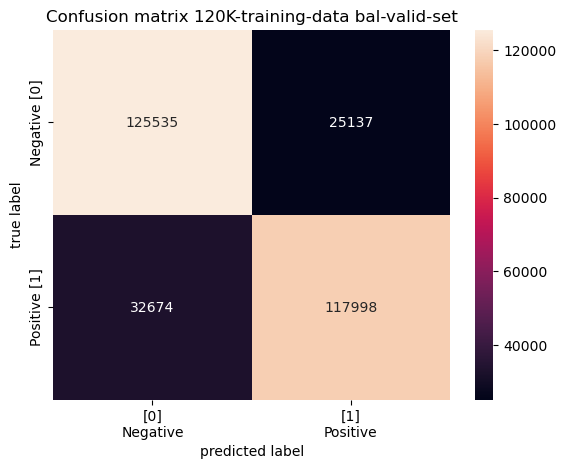

In [21]:
create_confusion_matrix_graph(y_bal_valid, y_bal_valid_pred, f'Confusion matrix {DATASET_LIST[DATASET_LIST_INDEX]}K-training-data bal-valid-set', save=False)

0.5144539031102926


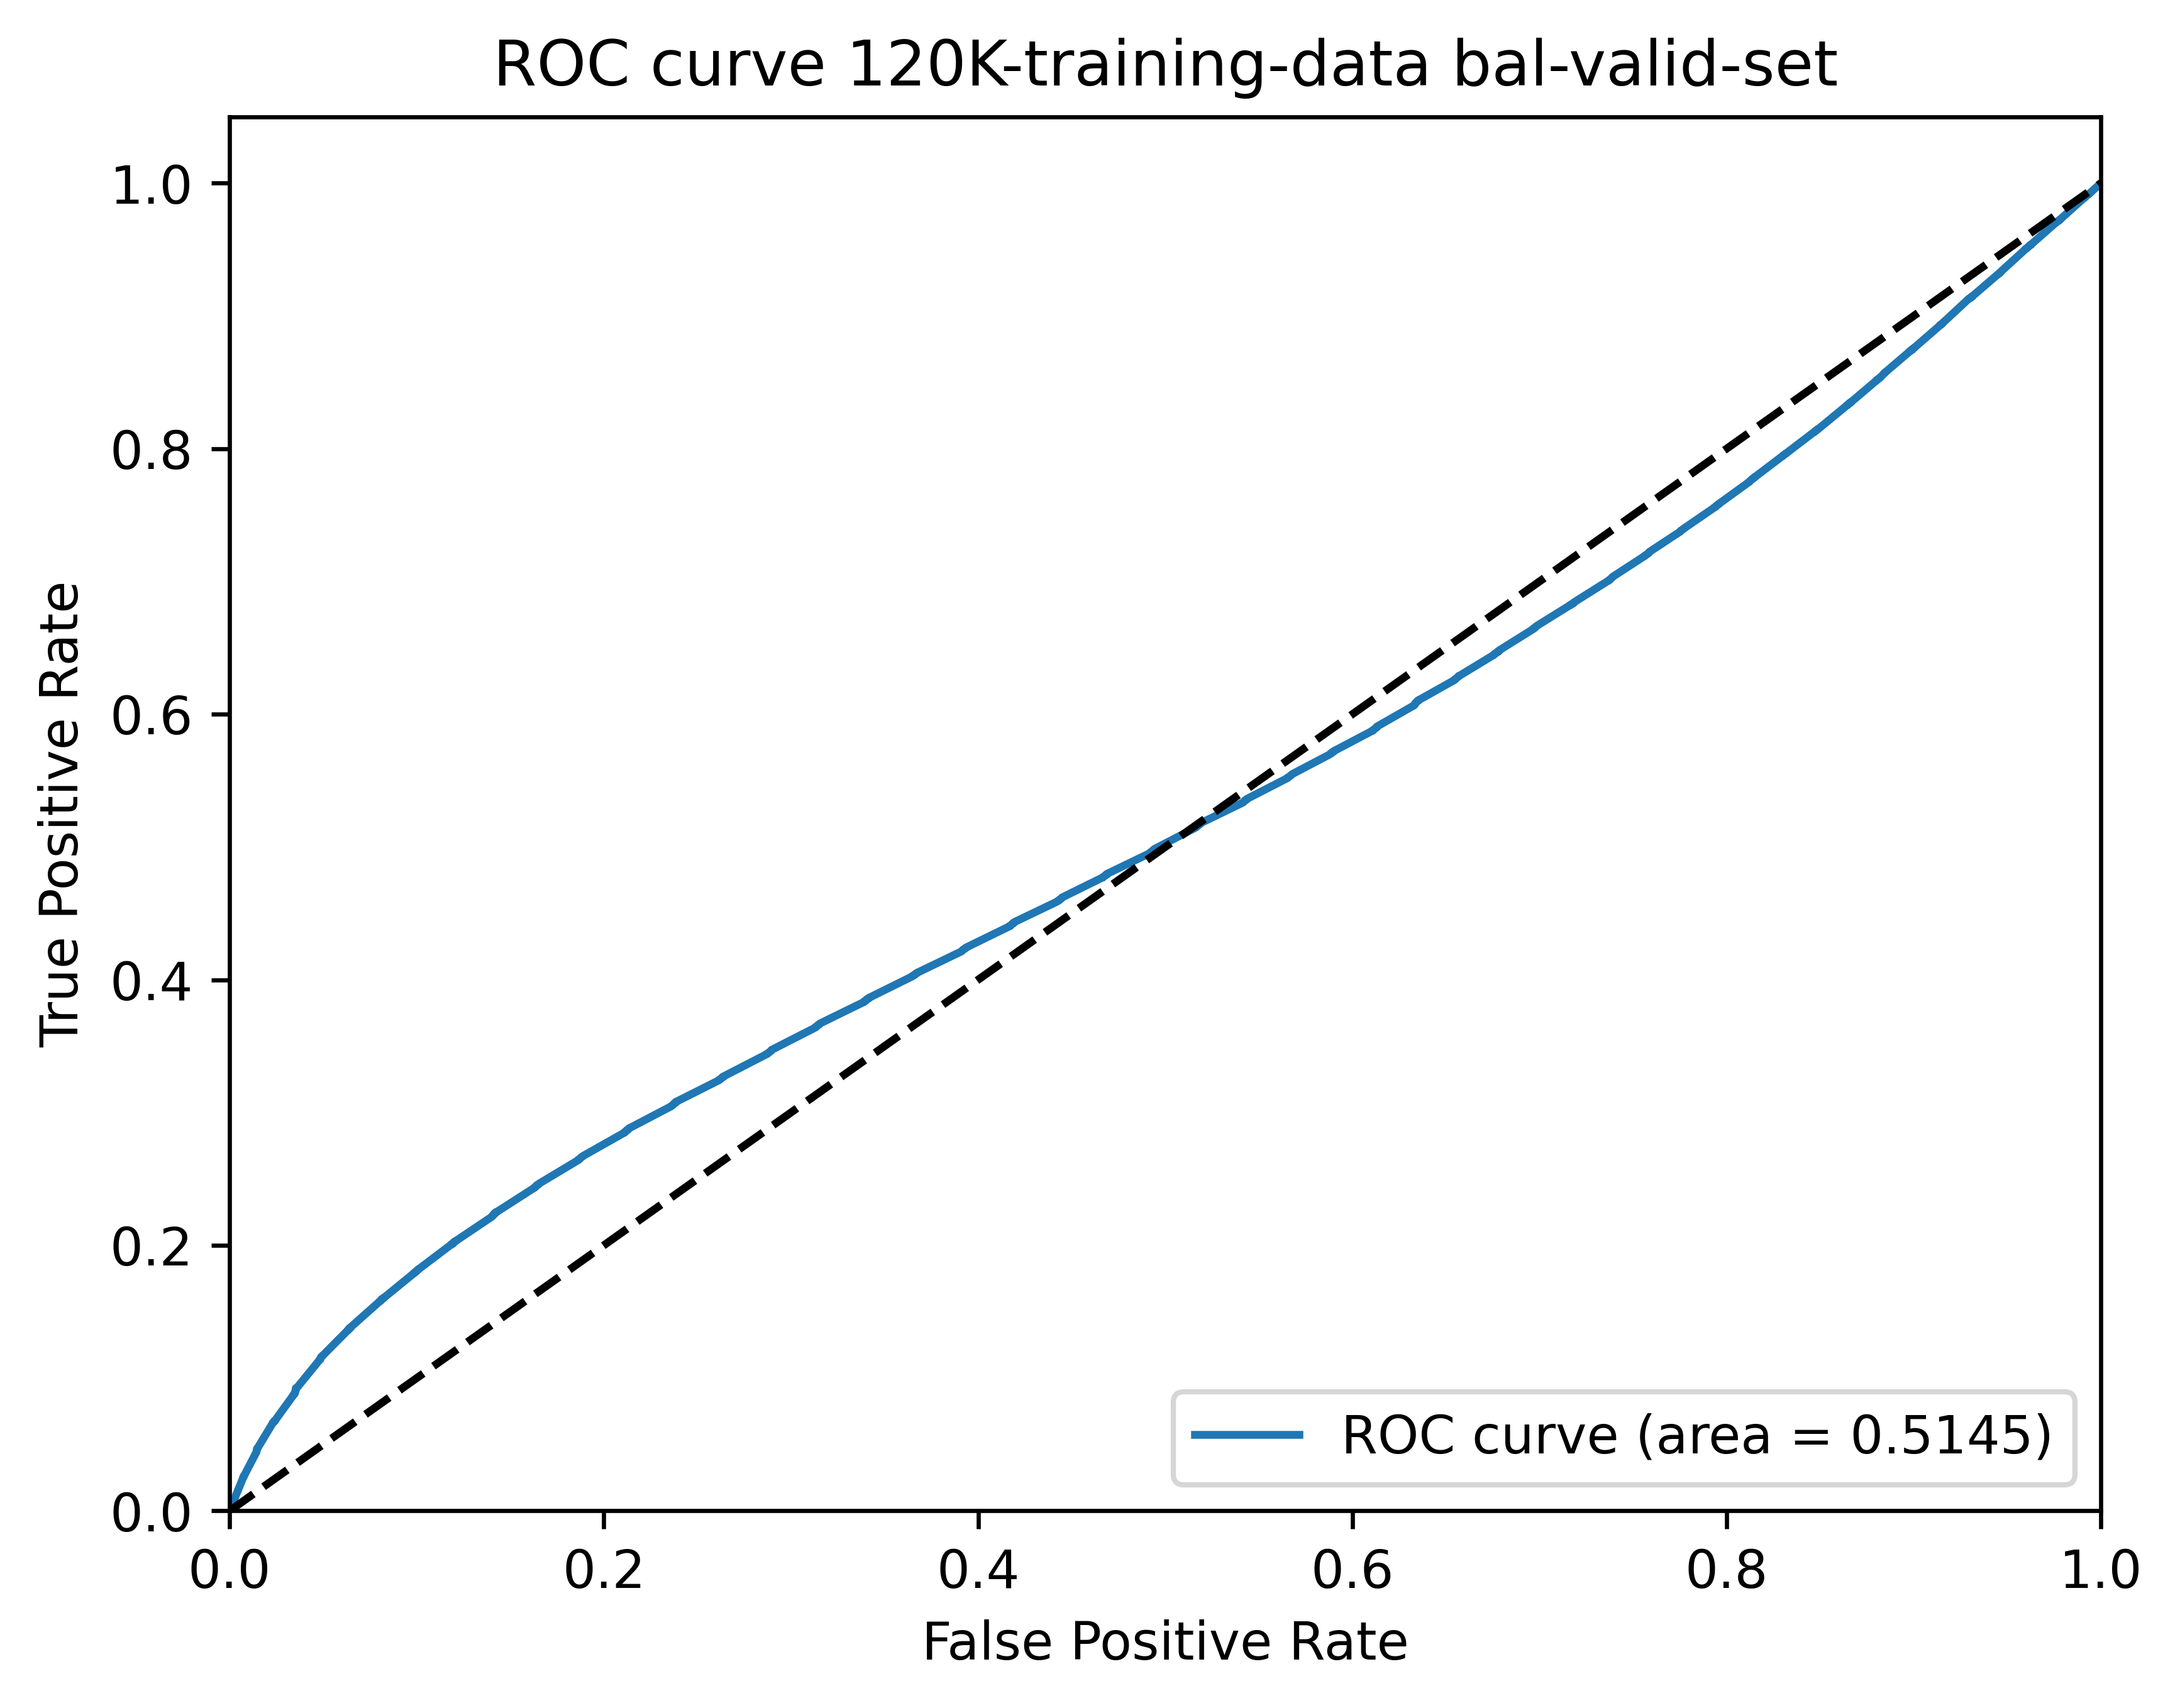

In [22]:
plot_roc_curve_binary(y_bal_valid, y_bal_valid_pred_prob, title=f'ROC curve {DATASET_LIST[DATASET_LIST_INDEX]}K-training-data bal-valid-set', save=False)

on fixed validation set (imbalanced)

In [15]:
y_imbal_valid_pred_prob_raw = pipeline_test.predict_proba(X_imbal_valid)

y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

In [16]:
print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.43      0.83      0.57    150928
           1       0.96      0.78      0.86    774377

    accuracy                           0.79    925305
   macro avg       0.70      0.81      0.72    925305
weighted avg       0.87      0.79      0.82    925305



TN - True Negative 125670
FN - False Negative 166597
TP - True Positive 607780
FP - False Positive 25258
Accuracy Rate: 0.7926575561571589
Misclassification Rate: 0.207342443842841
F1-Score: 0.7153959975301669
ROC-AUC 0.808755933479703


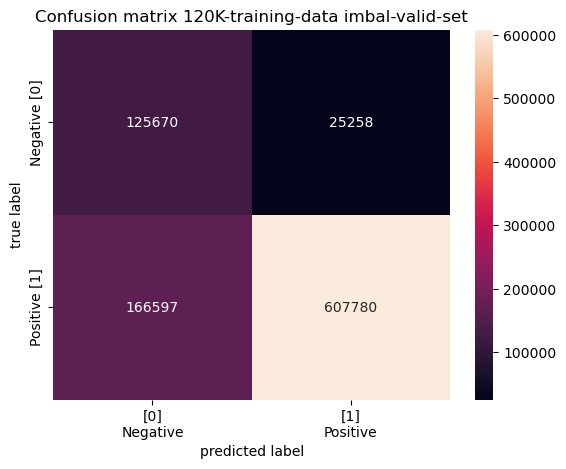

In [17]:
create_confusion_matrix_graph(y_imbal_valid, y_imbal_valid_pred, f'Confusion matrix {DATASET_LIST[DATASET_LIST_INDEX]}K-training-data imbal-valid-set', save=False)

0.5159886136364562


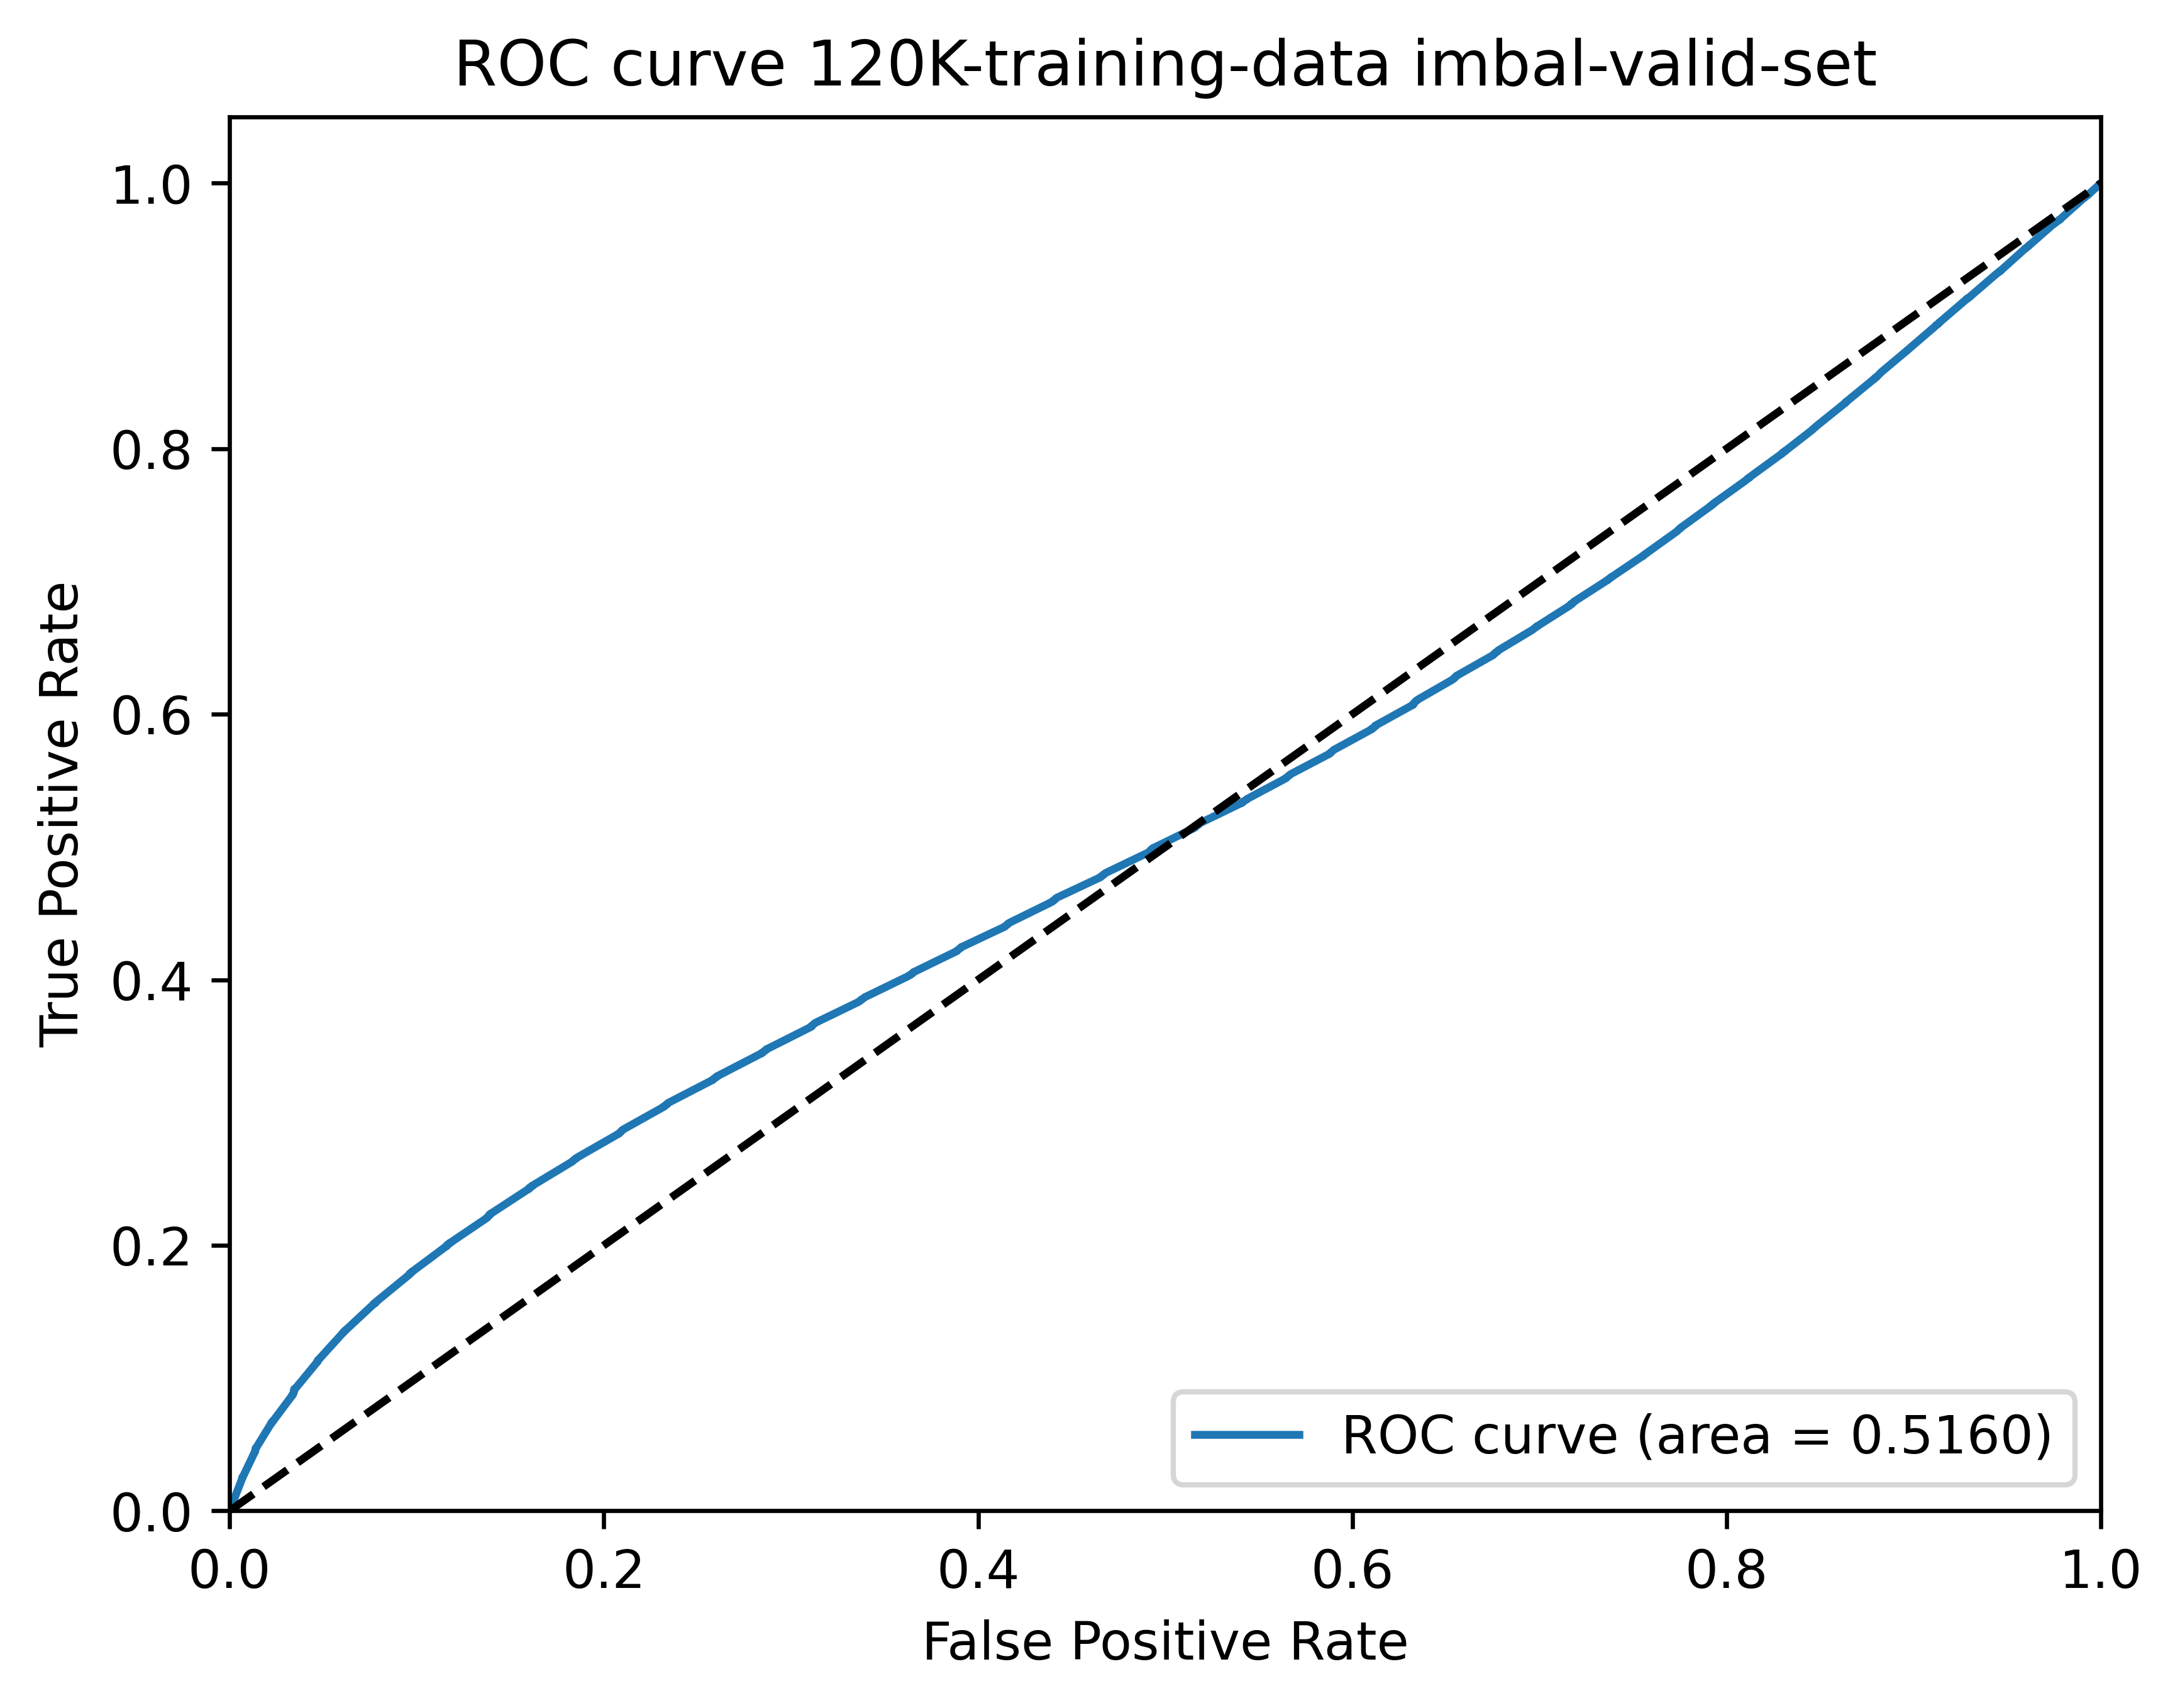

In [18]:
plot_roc_curve_binary(y_imbal_valid, y_imbal_valid_pred_prob, title=f'ROC curve {DATASET_LIST[DATASET_LIST_INDEX]}K-training-data imbal-valid-set', save=False)